In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import spacy
import spacy
import re

## Pré-processamento

In [615]:
df = pd.read_csv('factnews_dataset.csv')

#criar grupo treino e teste
train_df, test_df = train_test_split(df, test_size=0.7, random_state=42)

stop_words = set(stopwords.words('portuguese'))

#criar coluna tokens
train_df['tokens'] = train_df['sentences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))

# Tokenizar sem stopwords
train_df['tokens'] = train_df['tokens'].apply(lambda toks: [t for t in toks if t not in stop_words])

## Análise exploratória

Detetar palavras únicas entre as classes

In [616]:
classes = df['classe'].unique()

def palavras_unicas_por_classe(df, token_col):
    
    # contar tokens por classe
    tokens_por_classe = {}
    for classe in classes:
        linhas_classe = df[df['classe'] == classe][token_col].dropna()
        contagem = {}
        for lista in linhas_classe:
            for token in lista:
                if token in contagem:
                    contagem[token] += 1
                else:
                    contagem[token] = 1
        tokens_por_classe[classe] = contagem

    # detetar palavras exclusivas por classe
    palavras_unicas = {}
    for classe in classes:
        # lista de palavras das outras classes
        outras_palavras = []
        for outra_classe in classes:
            if outra_classe != classe:
                for token in tokens_por_classe[outra_classe]:
                    outras_palavras.append(token)

        # dicionário palavras exclusivas com contagens
        unicas_classe = {}
        for palavra, contagem in tokens_por_classe[classe].items():
            exclusiva = True
            for p in outras_palavras:
                if p == palavra:
                    exclusiva = False
                    break
            if exclusiva:
                unicas_classe[palavra] = contagem

        palavras_unicas[classe] = unicas_classe

        #manter as 10 mais comuns em cada classe
        ordenadas = dict(sorted(unicas_classe.items(), key=lambda item: item[1], reverse=True)[:10])

        palavras_unicas[classe] = ordenadas

    return palavras_unicas

print(palavras_unicas_por_classe(train_df,'tokens'))

palavras_unicas = palavras_unicas_por_classe(train_df,'tokens')


{-1: {'gente': 20, '...': 10, '!': 9, 'umas': 7, 'sr.': 7, 'fiz': 7, 'vou': 6, 'quero': 6, 'senhor': 6, 'vamos': 6}, 0: {'junho': 18, 'obras': 18, 'empresas': 18, 'primeira': 16, 'pf': 16, 'pista': 15, 'sul': 14, 'carlos': 14, 'nelson': 13, 'pediu': 12}, 1: {'ernaux': 5, 'colocar': 4, 'vê': 3, 'provocar': 3, 'colômbia': 2, 'sonora': 2, 'tesourada': 2, 'placar': 2, 'racha': 2, 'limites': 2}}


ver a proporção de advérbios e adjetivos entre as classes

In [ ]:
nltk.download('mac_morpho') 
from nltk.corpus import mac_morpho

dic_palavras = {}  # Dic para palavras de cada classe gramatical
for palavra, tag in mac_morpho.tagged_words():  # (palavra, tag)
    if tag not in dic_palavras: 
        dic_palavras[tag] = set()
    dic_palavras[tag].add(palavra.lower())  # associar palavra à respetiva tag

print (dic_palavras)

"nltk.download('mac_morpho') \nfrom nltk.corpus import mac_morpho\n\ndic_palavras = {}  # Dic para palavras de cada classe gramatical\nfor palavra, tag in mac_morpho.tagged_words():  # (palavra, tag)\n    if tag not in dic_palavras: \n        dic_palavras[tag] = set()\n    dic_palavras[tag].add(palavra.lower())  # associar palavra à respetiva tag\n\nprint (dic_palavras)"

Ver todos os tipos de token presentes no dataset

In [ ]:
print(dic_palavras.keys())

In [ ]:
def proporcao_adverbios_adjetivos_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()  
    proporcoes_por_classe = {}     

    lista_adverbios = dic_palavras.get('ADV', set())  
    lista_adjetivos = dic_palavras.get('ADJ', set())  
    lista_modais = dic_palavras.get('MD', set())
    
    for classe in classes: 
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()  
            
        total_adverbios_classe = 0   
        total_adjetivos_classe = 0    
        total_modais_classe = 0
        total_tokens_classe = 0

        # contar advérbios e adjetivos
        for lista_tokens in tokens_por_classe:
            total_adverbios_classe += sum(1 for token in lista_tokens if token in lista_adverbios)
            total_adjetivos_classe += sum(1 for token in lista_tokens if token in lista_adjetivos)
            total_modais_classe += sum(1 for token in lista_tokens if token in lista_modais)
            total_tokens_classe += len(lista_tokens)

        proporcoes_por_classe[classe] = {
            'total_adverbios': total_adverbios_classe,
            'media_adverbios_por_token': total_adverbios_classe / total_tokens_classe,
            'total_adjetivos': total_adjetivos_classe,
            'media_adjetivos_por_token': total_adjetivos_classe / total_tokens_classe,
            'total_modais': total_modais_classe,
            'media_modais_por_token': total_modais_classe / total_tokens_classe,
        }
    
    return proporcoes_por_classe

proporcao_adverbios_adjetivos_por_classe(train_df, 'tokens')

"def proporcao_adverbios_adjetivos_por_classe(df, coluna_tokens):\n    classes = df['classe'].unique()  \n    proporcoes_por_classe = {}     \n\n    lista_adverbios = dic_palavras.get('ADV', set())  \n    lista_adjetivos = dic_palavras.get('ADJ', set())  \n    lista_modais = dic_palavras.get('MD', set())\n    \n    for classe in classes: \n        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()  \n            \n        total_adverbios_classe = 0   \n        total_adjetivos_classe = 0    \n        total_modais_classe = 0\n        total_tokens_classe = 0\n\n        # contar advérbios e adjetivos\n        for lista_tokens in tokens_por_classe:\n            total_adverbios_classe += sum(1 for token in lista_tokens if token in lista_adverbios)\n            total_adjetivos_classe += sum(1 for token in lista_tokens if token in lista_adjetivos)\n            total_modais_classe += sum(1 for token in lista_tokens if token in lista_modais)\n            total_tokens_classe +

In [ ]:
def proporcao_palavras_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()
    proporcoes_por_classe = {}

    for classe in classes:
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()
        total_tokens_classe = sum(len(lista) for lista in tokens_por_classe)
        proporcoes_por_classe[classe] = {}

        for key in dic_palavras.keys():
            lista_tokens_tag = dic_palavras.get(key, set())
            total_palavras_tag = sum(
                1 for lista_tokens in tokens_por_classe for token in lista_tokens if token in lista_tokens_tag
            )
            if total_palavras_tag > 0:
                proporcoes_por_classe[classe][key] = {
                    'total': total_palavras_tag,
                    'media_por_token': total_palavras_tag / total_tokens_classe if total_tokens_classe else 0
                }

    return proporcoes_por_classe

resultados = proporcao_palavras_por_classe(train_df, 'tokens')

discrepancias = {}

for key in dic_palavras.keys():
    media_0 = resultados.get(0, {}).get(key, {}).get('media_por_token', 0)
    media_1 = resultados.get(1, {}).get(key, {}).get('media_por_token', 0)
    discrepancia = abs(media_0 - media_1)
    discrepancias[key] = (discrepancia, media_0, media_1)

chaves_ordenadas = sorted(discrepancias, key=lambda k: discrepancias[k][0], reverse=True)[:10]

for k in chaves_ordenadas:
    discrepancia, media_0, media_1 = discrepancias[k]
    print(f"{k}: classe 0 = {media_0:.4f}, classe 1 = {media_1:.4f}, diferença = {discrepancia:.4f}")

print(chaves_ordenadas)


'def proporcao_palavras_por_classe(df, coluna_tokens):\n    classes = df[\'classe\'].unique()\n    proporcoes_por_classe = {}\n\n    for classe in classes:\n        tokens_por_classe = df[df[\'classe\'] == classe][coluna_tokens].dropna()\n        total_tokens_classe = sum(len(lista) for lista in tokens_por_classe)\n        proporcoes_por_classe[classe] = {}\n\n        for key in dic_palavras.keys():\n            lista_tokens_tag = dic_palavras.get(key, set())\n            total_palavras_tag = sum(\n                1 for lista_tokens in tokens_por_classe for token in lista_tokens if token in lista_tokens_tag\n            )\n            if total_palavras_tag > 0:\n                proporcoes_por_classe[classe][key] = {\n                    \'total\': total_palavras_tag,\n                    \'media_por_token\': total_palavras_tag / total_tokens_classe if total_tokens_classe else 0\n                }\n\n    return proporcoes_por_classe\n\nresultados = proporcao_palavras_por_classe(train_df

ver média de classes gramaticais por frase entre classe

In [ ]:
nlp = spacy.load("pt_core_news_sm")

def media_classe_gramaticais_por_frase(data):
    classes = data['classe'].unique()
    resultados = {}
    
    for classe in classes:
        frases = data[data['classe'] == classe]['sentences']
        total_frases = len(frases)
    
        soma_categorias = defaultdict(int)
    
        for frase in frases:
            doc = nlp(frase)
            
            # Filtrar tokens que não são pontuação
            tokens_validos = [token for token in doc if not token.is_punct and not token.is_space]

            # Contar ocorrência de cada categoria gramatical nesta frase
            contagens_frase = defaultdict(int)
            for token in tokens_validos:
                categoria = token.pos_
                contagens_frase[categoria] += 1
            
            # Adicionar as contagens desta frase ao total
            for categoria, count in contagens_frase.items():
                soma_categorias[categoria] += count
        
        # Calcular a média para cada categoria
        medias_categoria = {}
        for categoria, soma_total in soma_categorias.items():
            medias_categoria[categoria] = soma_total / total_frases
        
        resultados[classe] = medias_categoria
    
    return resultados

media_gramatica_por_frase = media_classe_gramaticais_por_frase(train_df)

MÉDIAS DE OCORRÊNCIAS POR FRASE 

Classe: 0
NOUN: 4.8607
ADP: 4.2708
PROPN: 2.7074
VERB: 2.0747
DET: 1.9689
ADJ: 0.9837
NUM: 0.8529
ADV: 0.6498
CCONJ: 0.5292
PRON: 0.5152
AUX: 0.5066
SCONJ: 0.4319
SYM: 0.0615
PUNCT: 0.0070
INTJ: 0.0008

Classe: -1
NOUN: 4.1663
ADP: 2.8337
VERB: 2.5550
DET: 2.1369
PROPN: 1.3154
ADJ: 1.1125
PRON: 0.9682
ADV: 0.8435
AUX: 0.6968
CCONJ: 0.6577
SCONJ: 0.6430
NUM: 0.2176
PUNCT: 0.0073
SYM: 0.0024

Classe: 1
NOUN: 5.8589
ADP: 4.7362
VERB: 2.6871
DET: 2.3988
PROPN: 2.3926
ADJ: 1.3742
ADV: 0.9509
CCONJ: 0.7607
SCONJ: 0.7117
PRON: 0.6564
NUM: 0.5828
AUX: 0.5706
SYM: 0.0429
PUNCT: 0.0184


número médio de sinais de pontuação por frases entre as classes

In [ ]:
def media_pontuacao_por_frase(data):
    classes = data['classe'].unique()
    resultados = {}
    
    for classe in classes:
        frases = data[data['classe'] == classe]['sentences']
        total_frases = len(frases)
        
        total = 0
        
        for frase in frases:
            token = nlp(frase)
            contagem_frase = sum(1 for token in token if token.is_punct)
            total += contagem_frase
        
        media = total / total_frases 
        resultados[classe] = media
    
    return resultados

media_pontuacao = media_pontuacao_por_frase(train_df)

"def media_pontuacao_por_frase(data):\n    classes = data['classe'].unique()\n    resultados = {}\n    \n    for classe in classes:\n        frases = data[data['classe'] == classe]['sentences']\n        total_frases = len(frases)\n        \n        total = 0\n        \n        for frase in frases:\n            token = nlp(frase)\n            contagem_frase = sum(1 for token in token if token.is_punct)\n            total += contagem_frase\n        \n        media = total / total_frases \n        resultados[classe] = media\n    \n    return resultados\n\nmedia_pontuacao = media_pontuacao_por_frase(train_df)"

## Contruir regras para classificar o texto

Classificar Versão 1

In [623]:
def citacao(text):
    return '"' in str(text) or '“' in str(text) or '”' in str(text) or '[' in str(text) 

def bias(text):
    return '?' in str(text)

def classificar(row):
    if citacao(row['sentences']):
        return -1  
    if bias(row['sentences']):
        return 1
    return 0

Classificar Versão 2

In [624]:
def classificar_texto(row):
    texto = row['sentences'].lower()
    tokens_texto = nltk.word_tokenize(texto)
    tokens_set = set(tokens_texto)

    for classe, palavras_contagem in palavras_unicas.items():
        for palavra in palavras_contagem.keys():
            if palavra in tokens_set: 
                return classe

    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }
    #citacao
    if '"' in texto or '“' in texto or '”' in texto or "'" in texto or "[" in texto:
        return -1
    if any(verbo in texto for verbo in ['disse', 'afirmou', 'relatou', 'segundo', 'comentou']):
        pontos['citacao'] += 1
        

    #bias
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {
        'citacao': -1,
        'facto': 0,
        'bias': 1,
    }
    
    return mapa_classes[classe_max]


Classificar Versão 3

In [625]:
nlp = spacy.load("pt_core_news_sm")

def classificar_texto2(row, medias, chaves):
    texto = row['sentences'].lower()
    doc = nlp(texto)
    tags = [token.pos_ for token in doc]
    total_tokens = len(tags) 
    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }

    # Citacao
    if any(p in texto for p in ['"', '“', '”', "'", '[']):
        pontos['citacao'] += 2

    # Bias - estas regras de palavras podemos substituir pelas palavras unicas
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #a cena das médias
    for key in chaves:
        media_0 = medias.get(0, {}).get(key, {}).get('media_por_token', 0)
        media_1 = medias.get(1, {}).get(key, {}).get('media_por_token', 0)
        meio = (media_0 + media_1) / 2

        valor_frase = tags.count(key) / total_tokens

        if valor_frase >= meio:
            if media_0 < media_1:   
                pontos['bias'] += 1
            else:
                pontos['facto'] += 1 
        else:
            if media_1 < media_0:
                pontos['facto'] += 1
            else:
                pontos['bias'] += 1
    # Factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {'citacao': -1, 'facto': 0, 'bias': 1}
    return mapa_classes[classe_max]


Classificação versão 4

In [626]:
def proximidade_pontuacao(frase, medias_pontuacao):
    doc = nlp(frase)
    pontuacao_frase = sum(1 for token in doc if token.is_punct)
    
    melhor_diferenca = None
    classe_mais_proxima = None
    
    for classe, media_pontuacao in medias_pontuacao.items():
        diferenca = abs(pontuacao_frase - media_pontuacao)
        
        if melhor_diferenca is None or diferenca < melhor_diferenca:
            melhor_diferenca = diferenca
            classe_mais_proxima = classe
    
    return classe_mais_proxima

In [627]:
def proximidade_gramatical(frase, medias_por_classe):
    doc = nlp(frase)
    
    # Filtrar tokens que não são pontuação e contar categorias da frase
    categorias_frase = defaultdict(int)
    for token in doc:
        if not token.is_punct and not token.is_space:
            categoria = token.pos_
            categorias_frase[categoria] += 1
    
    proximidades = {}
    for categoria in categorias_frase:
        melhor_diferenca = None
        classe_mais_proxima =None
        for classe, medias in medias_por_classe.items():
            if categoria in medias.keys():
                diferenca = abs(categorias_frase[categoria] - medias[categoria])
                if melhor_diferenca is None or diferenca < melhor_diferenca:
                    melhor_diferenca = diferenca
                    classe_mais_proxima = classe
        proximidades[categoria] = classe_mais_proxima
    #print(proximidades)
    soma={}
    for categoria, classe in proximidades.items():
        soma [classe]= soma.get(classe,0) +1
        
    #print('somas', soma)
        
    max_valor = max(soma, key=soma.get)
    return max_valor




In [ ]:
def classificar_frase_gramaticalmente(row, medias_por_classe):
    
    frase = row['sentences'].lower()

    texto = nltk.word_tokenize(frase)
    
    #verificar se tem uma palavra única
    for classe, palavras_contagem in palavras_unicas.items():
        for palavra in palavras_contagem.keys():
            if palavra in texto: 
                return classe
    
    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }

    pontos_gramatica= proximidade_gramatical(frase, medias_por_classe)
    print('pontos gramatica', pontos_gramatica)
    if pontos_gramatica is not None:
        if pontos_gramatica == -1:
            pontos['citacao'] += 1
        elif pontos_gramatica == 0:
            pontos['facto'] += 1
        elif pontos_gramatica == 1:
            pontos['bias'] += 1
     
    

     #citacao
    if any(p in frase for p in ['"', '“', '”', "'", '[',]):
        pontos['citacao'] += +1
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1
    
    if any(adj in frase for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in frase for intens in ['muito', 'pouco','violentamento','claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 2
    if '?' in texto:
        pontos['bias'] += 1

    #factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', frase):
        pontos['facto'] += 2

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {'citacao': -1, 'facto': 0, 'bias': 1}
    return mapa_classes[classe_max]
    

ver verbo verbo numa frase - prob um bias

## Aplicar classificação no conjunto de teste

In [ ]:
test_df['Previsto'] = test_df.apply(classificar, axis=1)
test_df['Previsto2'] = test_df.apply(classificar_texto, axis=1)
test_df['Previsto3'] = test_df.apply(classificar_texto2, axis=1, args=(resultados, chaves_ordenadas))
test_df['Previsto4'] = test_df.apply(classificar_frase_gramaticalmente, axis=1, args=(media_gramatica_por_frase,) )

pontos gramatica 1
pontos gramatica -1
pontos gramatica -1
pontos gramatica 1
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica -1
pontos gramatica 1
pontos gramatica 1
pontos gramatica -1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica 0
pontos gramatica 1
pontos gramatica 0
pontos gramatica 1
pontos gramatica 0
pontos gramatica 0
pontos gramatica 0
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica -1
pontos gramatica -1
pontos gramatica 1
pontos gramatica 1
pontos gramatica -1
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica -1
pontos gramatica 0
pontos gramatica 1
pont

## Avaliar as regras de classificação

In [ ]:
print(test_df[['sentences', 'classe', 'Previsto', 'Previsto2', 'Previsto3', 'Previsto4']].head())

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

certos = (test_df['classe'] == test_df['Previsto']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

'from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\nimport matplotlib.pyplot as plt\n\ncertos = (test_df[\'classe\'] == test_df[\'Previsto\']).sum()\ntotal = len(test_df)\nprint(f\'Certos: {certos} de {total}\')\nprint(f\'Accuracy: {certos/total:.2%}\')\n\nfor c in classes:\n    linhas_classe = test_df[test_df[\'classe\'] == c]     \n    total_classe = len(linhas_classe)\n    certos_classe = (linhas_classe[\'classe\'] == linhas_classe[\'Previsto\']).sum()\n    taxa_acerto = certos_classe / total_classe \n    print(f"Classe {c}: ", taxa_acerto*100, "%")\n\nmatriz = confusion_matrix(test_df[\'classe\'], test_df[\'Previsto\'], labels=classes)\n\ndisp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)\ndisp.plot()\nplt.title("Matriz de confusão do teste")\nplt.show()'

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
certos = (test_df['classe'] == test_df['Previsto2']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto2']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto2'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

'certos = (test_df[\'classe\'] == test_df[\'Previsto2\']).sum()\ntotal = len(test_df)\nprint(f\'Certos: {certos} de {total}\')\nprint(f\'Accuracy: {certos/total:.2%}\')\n\nfor c in classes:\n    linhas_classe = test_df[test_df[\'classe\'] == c]     \n    total_classe = len(linhas_classe)\n    certos_classe = (linhas_classe[\'classe\'] == linhas_classe[\'Previsto2\']).sum()\n    taxa_acerto = certos_classe / total_classe \n    print(f"Classe {c}: ", taxa_acerto*100, "%")\n\nmatriz = confusion_matrix(test_df[\'classe\'], test_df[\'Previsto2\'], labels=classes)\n\ndisp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)\ndisp.plot()\nplt.title("Matriz de confusão do teste")\nplt.show()'

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
certos = (test_df['classe'] == test_df['Previsto3']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto3']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto3'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

'certos = (test_df[\'classe\'] == test_df[\'Previsto3\']).sum()\ntotal = len(test_df)\nprint(f\'Certos: {certos} de {total}\')\nprint(f\'Accuracy: {certos/total:.2%}\')\n\nfor c in classes:\n    linhas_classe = test_df[test_df[\'classe\'] == c]     \n    total_classe = len(linhas_classe)\n    certos_classe = (linhas_classe[\'classe\'] == linhas_classe[\'Previsto3\']).sum()\n    taxa_acerto = certos_classe / total_classe \n    print(f"Classe {c}: ", taxa_acerto*100, "%")\n\nmatriz = confusion_matrix(test_df[\'classe\'], test_df[\'Previsto3\'], labels=classes)\n\ndisp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)\ndisp.plot()\nplt.title("Matriz de confusão do teste")\nplt.show()'

Acertos: 2121 de 4334
Accuracy: 48.94%
Classe -1:  73.11608961303462 %
Classe 0:  40.75076090632398 %
Classe 1:  50.12658227848101 %


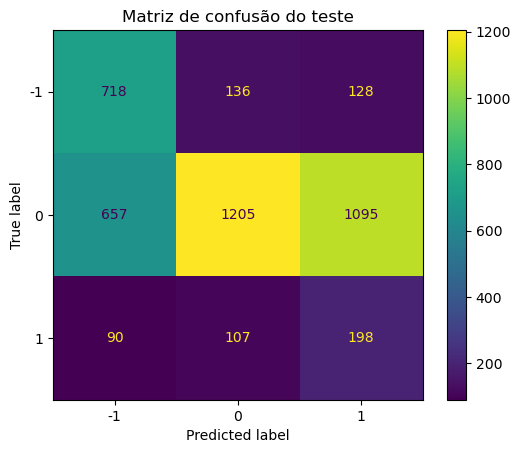

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
certos = (test_df['classe'] == test_df['Previsto4']).sum()
total = len(test_df)
print(f'Acertos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto4']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto4'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()